In [1]:
import json
import numpy as np
import pandas as pd
import sys
from zen_utils import Zen
import json
pd.options.display.float_format = '{:,.3f}'.format
base = Zen('2032.json')

In [2]:
bdf = base.db_df['reg_batting']#.sort_values('HR',ascending=False)
b = bdf[['H','2b','3b','HR']]
b.columns = ['H','Doub','Trip','HR']
b = b.assign(HR = b.HR.mul(3))
b = b.assign(Trip = b.Trip.mul(2))
b = b.assign(Doub = b.Doub.mul(1))
bdf['TB'] = b.sum(axis=1).values


def get_val(string):
    if 'Silver Slugger Award' in string:
        return 1
    if 'Most Valuable Player' in string:
        return 2
    return 0

x = [[[y['pid'],x['season'],get_val(x['type'])] for x in y['awards'] if get_val(x['type']) != 0] for y in base.player_list if y['awards']!=[]]
x = filter(lambda a: a != [], x)

vals = []
for z in x:
    for y in z:
        vals.append(y)
a = pd.DataFrame(vals,columns=['pid','year','awards'])


awards = []
for row in bdf.index:
    player = bdf.iloc[row]
    PID = player['pid']
    YEAR = player['year'] 
    b = a[(a['pid']==PID) & (a['year']==YEAR)].max(axis=0)['awards']
    if np.isnan(b) or player['pos'] == 'p':
        b = 0
    awards.append(b)
bdf = bdf.assign(award = awards)

In [3]:
regression_df = bdf[['year','tid','pid','AB','H','2b','3b','HR','TB','R','RBI','SB','BB','K','E','pos','award']]
regression_df.columns = ['year','tid','pid','AB','H','h2b','h3b','HR','TB','R','RBI','SB','BB','K','E','pos','award']
regression_df = regression_df[regression_df['AB']!=0]
r = regression_df.assign(WAR = regression_df.HR.mul(0.92))
r = r.assign(WAR = r.WAR+r.h3b.mul(0.62)+r.h2b.mul(0.3)+r.H.mul(0.47)+r.BB.mul(0.32)+r.SB.mul(0.16)+r.K.mul(-0.3)+r.E.mul(-0.24))
replacement = r.sum(axis=0)['WAR']/float(len(r))-20
r = r.assign(WAR = (r.WAR+replacement)/6.5)
r = r.assign(WAR = r.WAR/3.5)
r_bat = r[r['pos']=='f'][r.columns.drop('pos')]
r_pit = r[r['pos']=='p'][r.columns.drop('pos')]
r_bat.index = np.array(range(len(r_bat)))
r_pit.index = np.array(range(len(r_pit)))

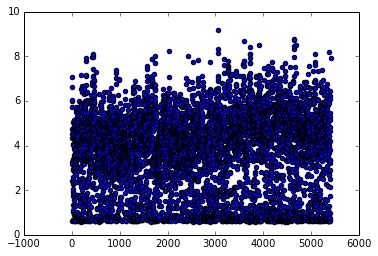

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(range(len(r_bat)),r_bat.WAR)

In [4]:
tdf = base.get_team_pitching_df('reg_pitching')[['W','tid']]

In [5]:
r = r_bat
r = r.assign(H = (r.H/r.AB)/(np.max(r.H)/r.AB)) 
r = r.assign(h2b = (r.h2b/r.AB)/(np.max(r.h2b)/r.AB))
r = r.assign(h3b = (r.h3b/r.AB)/(np.max(r.h3b)/r.AB))
r = r.assign(HR = (r.HR/r.AB)/(np.max(r.HR)/r.AB))
r = r.assign(TB = (r.TB/r.AB)/(np.max(r.TB)/r.AB))
r = r.assign(R = (r.R/r.AB)/(np.max(r.R)/r.AB))
r = r.assign(RBI = (r.RBI/r.AB)/(np.max(r.RBI)/r.AB))
r = r.assign(SB = (r.SB/r.AB)/(np.max(r.SB)/r.AB))
r = r.assign(BB = (r.BB/r.AB)/(np.max(r.BB)/r.AB))
r = r.assign(K = (r.K/r.AB)/(np.max(r.K)/r.AB))
r = r.assign(E = r.E/np.max(r.E))
vals = []
for x in r.index:
    vals.append(tdf[tdf.tid == r.iloc[x]['tid']]['W'].values[0])
vals = np.array(vals)
r = r.assign(Wins = vals)

In [6]:
teamwar = []
for x in range(np.max(tdf.tid)):
    teamwar.append(r[r.tid==x].sum(axis=0)['WAR'])
teamwar = np.array([np.array(teamwar),np.array(teamwar)])
temp = pd.DataFrame(teamwar.T,columns=['WAR','temp'],index=range(len(teamwar[0])))
temp = temp[temp.columns.drop('temp')]
temp['tid'] = temp.index
temp = temp[temp.WAR>0]
a = tdf[['W','tid']].values.T[0]
a = a[a>0]
WARtoWins = temp.assign(Wins = a)
WARtoWins = WARtoWins[['WAR','Wins']]
sums = r[[u'H', u'h2b', u'h3b', u'HR', u'TB',u'R', u'RBI', u'SB', u'BB', u'K']].sum(axis=1)
temp = pd.DataFrame(np.array([r.tid.values,sums.values]).T,columns=['tid','sums'])
a = np.array([temp[temp.tid==x].sum(axis=0)['sums'] for x in range(len(temp))])
a = a[np.where(a>0)]
sums = WARtoWins.assign(sums=a)
sums = sums[['sums','WAR','Wins']]

In [7]:
X_train2 = r[['H','h2b','h3b','HR','R','RBI','SB','BB','K']]
X_train = r[['H','TB','R','RBI','SB','BB','K']]
y_train = r['award']

In [10]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True, n_jobs=None,normalize=False)
reg.fit(X_train,y_train)
reg.coef_
reg.intercept_
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train,y_train)
reg.coef_
reg.intercept_
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
clf = SVC(C=2.0,kernel='linear',gamma='auto',degree=3)
clf.fit(X_train.values, y_train) 
svm_coef_tb = clf.coef_
svm_int_tb = clf.intercept_


from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
clf = SVC(C=2.0,kernel='linear',gamma='auto',degree=3)
clf.fit(X_train2.values, y_train) 
svm_coef = clf.coef_
svm_intercept = clf.intercept_

In [8]:
#HRS
svm_coef = [ -1.31718095e-03,   8.25973383e-04,   2.70776237e-04, -1.94661820e-04,  -4.63461908e-04,   3.99370524e-04,3.55218773e-04,1.09042579e-03,4.62994671e-04]
svm_intercept = 0.99997506
basic_coef = [ 0.07910387, -0.17608462, -0.02260266, -0.15004652,  0.3428496 , 0.28757438,  0.00812146,  0.00252246, -0.28827095]
basic_intercept = -0.018277887873559537
ridge_coef = [ 0.08070927, -0.17039411, -0.02096716, -0.13389261,  0.32501322, 0.27432563,  0.01204154,  0.00736691, -0.28332797]
ridge_intercept = -0.018419734609498493

In [9]:
#TB
basic_coef_tb = [ 0.27307789, -0.5023389 ,  0.35271138,  0.29355734,  0.00827383, -0.00866019, -0.27855839]
basic_int_tb = -0.018263215128242499
ridge_coef_tb = [ 0.23155731, -0.41806065,  0.31632032,  0.26814151,  0.01574196, 0.00551388, -0.27037517]
ridge_int_tb = -0.018495008159907622
svm_coef_tb = [ -1.64076986e-03,   2.10818231e-03,  -3.91985412e-04,-9.44808284e-04,  -1.96758135e-04,  -2.92464807e-04,8.92837295e-05]
svm_int_tb = 1.00069019

In [11]:
regular = r[['H','h2b','h3b','HR','R','RBI','SB','BB','K']]
tb = r[['H','TB','R','RBI','SB','BB','K']]

In [12]:
basicTB = np.dot(tb.values,basic_coef_tb)+basic_int_tb
ridgeTB = np.dot(tb.values,ridge_coef_tb)+ridge_int_tb
svmTB = np.add(np.dot(tb.values,svm_coef_tb.T),svm_int_tb)
basic = np.dot(regular.values,basic_coef)+basic_intercept
ridge = np.dot(regular.values,ridge_coef)+ridge_intercept
svm = np.add(np.dot(regular.values,svm_coef.T),svm_intercept)

In [13]:
svm = pd.DataFrame(svm).sum(axis=1).values
svmTB = pd.DataFrame(svmTB).sum(axis=1).values

In [14]:
temp = pd.DataFrame(np.array([r.tid,basicTB,ridgeTB,svmTB,basic,ridge,svm]).T,columns=['tid','basicTB','ridgeTB','svmTB','basic','ridge','svm'])
a = pd.DataFrame(np.array([temp[temp.tid==x].sum(axis=0)[['basicTB','ridgeTB','svmTB','basic','ridge','svm']] for x in range(len(temp))]),columns=['basicTB','ridgeTB','svmTB','basic','ridge','svm'])

In [210]:
correlations = pd.concat([a,sums],axis=1)

In [222]:
correlations = correlations[(correlations.basic!=0)&(correlations.svm!=0)]

In [226]:
correlations.to_csv("./correlations.csv")

In [224]:
from sklearn import preprocessing

x = correlations.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
correlations = pd.DataFrame(x_scaled,columns=correlations.columns)

In [241]:
# plt.scatter(correlations.Wins,correlations.WAR)
# plt.scatter(correlations.Wins,correlations.basic,c='green')
# plt.scatter(correlations.Wins,correlations.ridge,c='red')
# plt.scatter(correlations.Wins,correlations.svm,c='purple')
# plt.scatter(correlations.Wins,correlations.basicTB,c='black')
# plt.scatter(correlations.Wins,correlations.ridgeTB,c='orange')
# plt.scatter(correlations.Wins,correlations.svmTB,c='pink')
# plt.scatter(correlations.Wins,correlations.sums,c='brown')





In [6]:
'''
do a bunch of analysis stuff
(stacked crosstab)
write about transforms done in python
normalize data
"multiply by abs or no"
histogram of stats
'''

'\ndo a bunch of analysis stuff\n(stacked crosstab)\nwrite about transforms done in python\nnormalize data\n"multiply by abs or no"\nhistogram of stats\n'

In [7]:
'''
get correlation of war to wins
get basic baseline of adding up stats
get basic baseline of linear model nothing fancy (regression to awards), apply weights
get slightly more complicated (cv, ridge regression) apply weights
svm nonlinear classifier
boosted regression

see how all of these correlate to wins, see if we can beat war
'''

'\nget correlation of war to wins\nget basic baseline of adding up stats\nget basic baseline of linear model nothing fancy (regression to awards), apply weights\nget slightly more complicated (cv, ridge regression) apply weights\nsvm nonlinear classifier\nboosted regression\n\nsee how all of these correlate to wins, see if we can beat war\n'

In [54]:
r.to_csv("./averaged_batstats.csv")
# W_df.to_csv("./wins_to_tid.csv")
# r_bat.to_csv("./raw_batstats.csv")